<a href="https://colab.research.google.com/github/deepurake/LLM-scratchpad/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from google.colab import files

files.upload()

Saving snli_1.0_train.csv to snli_1.0_train.csv


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


# # Create a folder in the root directory
# !mkdir -p "/content/drive/My Drive/My Folder"

<Axes: >

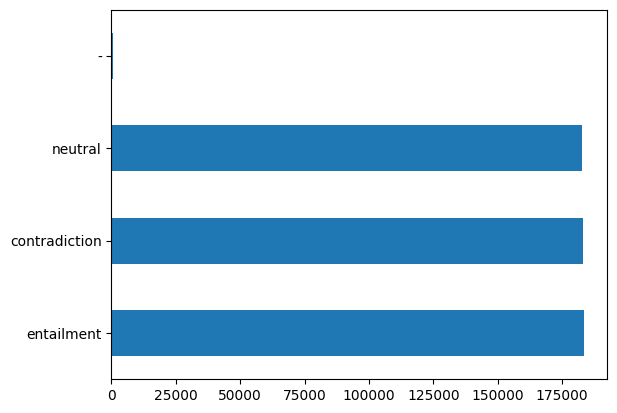

In [6]:
df = pd.read_csv('/content/drive/My Drive/My Folder/snli_1.0_train.csv')
df['gold_label'].value_counts().plot(kind='barh')


In [7]:
def convert_to_format(row):
    sentence1 = row['sentence1']
    sentence2 = row['sentence2']
    prompt = """Below is an instruction that describes a task paired with input that provides further context. Write a response that appropriately completes the request."""
    instruction = """Given the following sentence, your job is to generate the negation for it in the json format"""
    input = str(sentence1)
    response = f"""```json
{{'orignal_sentence': '{sentence1}', 'generated_negation': '{sentence2}'}}
```
"""
    if len(input.strip()) == 0:  #  prompt + 2 new lines + ###instruction + new line + input + new line + ###response
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Response:\n" + response
    else:
        text = prompt + "\n\n### Instruction:\n" + instruction + "\n### Input:\n" + input + "\n" + "\n### Response:\n" + response

    # we need 4 columns for auto train, instruction, input, output, text
    return pd.Series([instruction, input, response, text])

new_df = df[df['gold_label'] == 'contradiction'][['sentence1', 'sentence2']].apply(convert_to_format, axis=1)
new_df.columns = ['instruction', 'input', 'output', 'text']

new_df.to_csv('snli_instruct.csv', index=False)


In [8]:
new_df.sample(10)

,instruction,input,output,text
389657,"Given the following sentence, your job is to g...",Quarterback ruft einen Timeout während eines S...,```json\n{'orignal_sentence': 'Quarterback ruf...,Below is an instruction that describes a task ...
42592,"Given the following sentence, your job is to g...","Die Leute sind in einem Netzcafé, der Hintergr...",```json\n{'orignal_sentence': 'Die Leute sind ...,Below is an instruction that describes a task ...
430121,"Given the following sentence, your job is to g...",Blau-graues Segelboot im Wasser mit ein paar a...,```json\n{'orignal_sentence': 'Blau-graues Seg...,Below is an instruction that describes a task ...
283214,"Given the following sentence, your job is to g...",Ein Fußballnetz bei Sonnenuntergang.,```json\n{'orignal_sentence': 'Ein Fußballnetz...,Below is an instruction that describes a task ...
420658,"Given the following sentence, your job is to g...","Eine Menschenmenge wartet darauf, eine Straße ...",```json\n{'orignal_sentence': 'Eine Menschenme...,Below is an instruction that describes a task ...
413549,"Given the following sentence, your job is to g...",Musiker bei der Arbeit; einer spielt das Schla...,```json\n{'orignal_sentence': 'Musiker bei der...,Below is an instruction that describes a task ...
367414,"Given the following sentence, your job is to g...",Eine Gruppe lächelnder Frauen.,```json\n{'orignal_sentence': 'Eine Gruppe läc...,Below is an instruction that describes a task ...
355454,"Given the following sentence, your job is to g...","Ein temperamentvolles Hockeyspiel, bei dem die...",```json\n{'orignal_sentence': 'Ein temperament...,Below is an instruction that describes a task ...
275078,"Given the following sentence, your job is to g...",Ein weißer Hund läuft durch ein Feld.,```json\n{'orignal_sentence': 'Ein weißer Hund...,Below is an instruction that describes a task ...
440879,"Given the following sentence, your job is to g...","Eine Frau, die tagsüber über eine Bar springt.","```json\n{'orignal_sentence': 'Eine Frau, die ...",Below is an instruction that describes a task ...


In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7


In [ ]:
new_df_trunc = new_df.sample(10000)

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
from datasets import Dataset

dataset = Dataset.from_pandas(new_df_trunc)

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "abhishek/llama-2-7b-hf-small-shards"

# Fine-tuned model name
new_model = "llama-2-contradictor"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 1e-5

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
# max_steps = -1
max_steps = 1500

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 100

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
# max_seq_length = None
max_seq_length = 512

# Pack multiple short examples in the same input sequence to increase efficiency
packing = True

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"



In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

In [ ]:
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",  # this is the text column in dataset
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    #packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
100,2.174200
200,1.242400
300,0.658400
400,0.575300
500,0.574400
600,0.513000
700,0.486300
800,0.473000
900,0.482900
1000,0.466800


In [ ]:
!zip -r llama-contradictor.zip results llama-contradictor
!mv llama-contradictor.zip /content/drive/MyDrive

	zip warning: name not matched: llama-contradictor
  adding: results/ (stored 0%)
  adding: results/runs/ (stored 0%)
  adding: results/runs/Feb01_07-33-19_4b6a6d9fa75e/ (stored 0%)
  adding: results/runs/Feb01_07-33-19_4b6a6d9fa75e/events.out.tfevents.1706773606.4b6a6d9fa75e.294.0 (deflated 61%)
  adding: results/runs/Feb02_02-53-31_0f3ebf8823c6/ (stored 0%)
  adding: results/runs/Feb02_02-53-31_0f3ebf8823c6/events.out.tfevents.1706842435.0f3ebf8823c6.8772.0 (deflated 60%)


In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7
!pip install peft==0.3.0

from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from google.colab import files


In [ ]:
from huggingface_hub import login
from google.colab import userdata

import os

access_token = userdata.get('HF_TOKEN')
login(token=access_token)

In [ ]:
!unzip /content/drive/MyDrive/llama-contradictor.zip -d .

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
# The model that you want to train from the Hugging Face hub
model_name = "abhishek/llama-2-7b-hf-small-shards"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

torch.cuda.empty_cache()
import gc
gc.collect()

base_model = AutoModelForCausalLM.from_pretrained(
    "abhishek/llama-2-7b-hf-small-shards",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
)



In [ ]:
model = PeftModel.from_pretrained(base_model, '/content/llama-contradictor')
model = model.merge_and_unload()
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)

In [ ]:
prompt_template = """### Instruction:
Given the following sentence, your job is to generate the negation for it in the json format
### Input:
{}

### Response:
"""

sentence = "The weather forecast predicts a sunny day with a high temperature around 30 degrees Celsius, perfect for a day at the beach with friends and family."

input_sentence = prompt_template.format(sentence.strip())

result = pipe(input_sentence)
print(result)